In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Pruning_try

after_comments_pruning.ipynb  conv_pruned_trained_alexnet2.h5  second_try.ipynb  try.ipynb
AlextNet_Cifar10.h5	      conv_pruned_trained_alexnet.h5   third_try.ipynb


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [ ]:
# Function to measure inference time per layer with CIFAR-10 test data
def measure_layer_inference_time_with_dataset(model, dataset):
    """
    Measure the average inference time for each convolutional layer in the model
    using the CIFAR-10 test dataset.

    Args:
    model -- TensorFlow/Keras model
    dataset -- tf.data.Dataset for CIFAR-10 test data

    Returns:
    layer_time -- List of tuples (layer_name, average_inference_time_per_batch)
    """
    # Initialize a list to store inference times per layer
    layer_time = []
    # Create a dictionary to store inference times for each Conv2D layer
    batch_times = {layer.name: [] for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)}

    # Iterate through batches in the dataset
    for x_batch, _ in dataset:
        # Use the batch as input for the model
        input_data = x_batch
        for layer in model.layers:
            # Check if the layer is a Conv2D layer
            if isinstance(layer, tf.keras.layers.Conv2D):
                # Measure the start time for this layer
                start_time = time.time()
                # Forward pass through the layer
                _ = layer(input_data)
                # Measure the elapsed time for this layer
                elapsed_time = time.time() - start_time
                # Store the elapsed time for this layer
                batch_times[layer.name].append(elapsed_time)

            try:
                # Pass the data through the current layer for the next layer
                input_data = layer(input_data)
            except:
                # Skip layers that are incompatible with direct forward pass
                pass

    # Compute the average inference time for each Conv2D layer
    for layer_name, times in batch_times.items():
        if times:  # Ensure the layer has recorded times
            # Calculate the average time for the layer
            average_time = sum(times) / len(times)
            # Append the layer name and average time to the results
            layer_time.append((layer_name, average_time))

    # Sort the layers by inference time in descending order
    return sorted(layer_time, key=lambda x: x[1], reverse=True)


In [ ]:
# Function to prune weights for a single layer
def prune_layer_weights(model, layer_name, sparsity):
    """
    Prune weights for a specific layer by setting low-magnitude weights to zero.

    Args:
    model -- TensorFlow/Keras model
    layer_name -- Name of the layer to prune
    sparsity -- Fraction of weights to set to zero (0 to 1)
    """
    # Iterate through all layers in the model
    for layer in model.layers:
        # Check if the current layer matches the specified layer name
        if layer.name == layer_name:
            # Get the weights of the layer
            weights = layer.get_weights()
            # Check if the layer has weights (not all layers do)
            if len(weights) > 0:
                # Extract the kernel weights (first element of the weights list)
                kernel = weights[0]
                # Compute the threshold for pruning based on sparsity
                threshold = np.percentile(np.abs(kernel), sparsity * 100)
                # Prune the kernel by setting values below the threshold to zero
                pruned_kernel = np.where(np.abs(kernel) < threshold, 0, kernel)
                # Update the layer's weights with the pruned kernel and original biases
                layer.set_weights([pruned_kernel, weights[1]])
                # Print confirmation of pruning
                print(f"Layer {layer_name} pruned to {sparsity * 100}% sparsity.")
                # Exit the loop after pruning the specified layer
                break

In [ ]:
# Function to measure average inference time for the entire test dataset
def measure_inference_time(model, dataset):
    """
    Measure average inference time for the entire dataset.

    Args:
    model -- TensorFlow/Keras model
    dataset -- tf.data.Dataset for evaluation

    Returns:
    avg_time_per_sample -- Average inference time per sample (milliseconds)
    """
    # Initialize a variable to accumulate total inference time
    total_time = 0
    # Initialize a variable to count the total number of samples
    total_samples = 0

    # Iterate through each batch in the dataset
    for x_batch, _ in dataset:
        # Record the start time of inference
        start_time = time.time()
        # Perform inference on the batch without updating weights
        _ = model(x_batch, training=False)
        # Add the time taken for this batch to the total time
        total_time += time.time() - start_time
        # Increment the total sample count by the number of samples in the batch
        total_samples += x_batch.shape[0]

    # Calculate the average inference time per sample
    avg_time_per_sample = total_time / total_samples
    # Convert the average time to milliseconds and return it
    return avg_time_per_sample * 1e3  # Return time in milliseconds per sample

In [ ]:
# Function to measure total inference time for all images in the test set
def measure_total_inference_time(model, dataset):
    """
    Measure the total inference time for the entire test dataset.

    Args:
    model -- TensorFlow/Keras model
    dataset -- tf.data.Dataset for evaluation

    Returns:
    total_inference_time -- Total inference time for the dataset (seconds)
    """
    # Initialize a variable to accumulate the total inference time
    total_time = 0

    # Iterate through each batch in the dataset
    for x_batch, _ in dataset:
        # Record the start time of inference for the current batch
        start_time = time.time()
        # Perform inference on the batch without updating weights
        _ = model(x_batch, training=False)  # Perform inference
        # Add the time taken for the current batch to the total time
        total_time += time.time() - start_time

    # Return the total inference time for the dataset in seconds
    return total_time  # Total time in seconds

In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
y_train, y_test = y_train.flatten(), y_test.flatten()  # Flatten labels

# Create a dataset for testing
batch_size = 32
dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [ ]:
# Load the model
model_path = "/content/drive/MyDrive/Pruning_try/AlextNet_Cifar10.h5"  # Replace with the path to your .h5 file
model = tf.keras.models.load_model(model_path)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 32, 32, 56)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 16, 16, 56)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 16, 16, 120)         │         168,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 8, 8, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 8, 8, 192)           │         207,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 192)           │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 8, 8, 128)           │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 2048)                │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,343,714 (35.64 MB)

 Trainable params: 9,343,714 (35.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Measure baseline accuracy and inference time
baseline_loss, baseline_accuracy = model.evaluate(dataset_test, verbose=0)
print(f"Baseline accuracy: {baseline_accuracy * 100:.2f}%")
baseline_inference_time = measure_inference_time(model, dataset_test)
print(f"Baseline inference time: {baseline_inference_time:.3f} ms/sample")

Baseline accuracy: 79.24%
Baseline inference time: 0.454 ms/sample


In [ ]:
# Measure the total inference time for CIFAR-10 test set
total_inference_time = measure_total_inference_time(model, dataset_test)
print(f"Total inference time for CIFAR-10 test set: {total_inference_time:.3f} seconds")

Total inference time for CIFAR-10 test set: 3.708 seconds


In [ ]:
# Measure average inference time for convolutional layers using CIFAR-10 dataset
layer_inference_time = measure_layer_inference_time_with_dataset(model, dataset_test)

# Print results
print("Average inference time per convolutional layer (batch size = 32):")
for layer_name, avg_time in layer_inference_time:
    print(f"Layer {layer_name}: {avg_time:.6f} seconds per batch")

Average inference time per convolutional layer (batch size = 32):
Layer conv2d_25: 0.001816 seconds per batch
Layer conv2d_28: 0.001234 seconds per batch
Layer conv2d_27: 0.001231 seconds per batch
Layer conv2d_29: 0.001231 seconds per batch
Layer conv2d_26: 0.001226 seconds per batch


In [ ]:
# Sort layers by their inference time dynamically
layer_time_sorted = sorted(layer_inference_time, key=lambda x: x[1], reverse=True)
print (layer_time_sorted)

[('conv2d_25', 0.0018158065625273), ('conv2d_28', 0.0012337712053292857), ('conv2d_27', 0.0012312651442262692), ('conv2d_29', 0.0012307128967187656), ('conv2d_26', 0.001225744192592633)]


In [ ]:
# Prune layers based on highest inference time and evaluate accuracy and latency
# Define the sparsity levels to test for pruning
sparsity_levels = [0.2, 0.4, 0.6, 0.8]  # Fraction of weights to set to zero
# Initialize a dictionary to store results for each layer, sparsity level, accuracy, and latency
results = {"Layer": [], "Sparsity": [], "Accuracy": [], "Latency": []}

# Iterate through layers sorted by descending inference time
for layer_name, _ in layer_time_sorted:
    # Test each sparsity level for the current layer
    for sparsity in sparsity_levels:
        # Restore the original model from the saved path for each pruning test
        model = tf.keras.models.load_model(model_path)
        # Compile the model with standard optimizer, loss function, and metrics
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Prune the weights of the specified layer to the given sparsity level
        prune_layer_weights(model, layer_name, sparsity)

        # Evaluate the pruned model on the test dataset to get accuracy and loss
        loss, accuracy = model.evaluate(dataset_test, verbose=0)
        # Measure the inference latency of the pruned model
        latency = measure_inference_time(model, dataset_test)

        # Record the results of the pruning experiment
        results["Layer"].append(layer_name)  # Store the name of the pruned layer
        results["Sparsity"].append(sparsity)  # Store the sparsity level
        results["Accuracy"].append(accuracy * 100)  # Store accuracy as a percentage
        results["Latency"].append(latency)  # Store the measured latency in ms/sample

        # Print a summary of the pruning results for the current layer and sparsity level
        print(f"Layer: {layer_name}, Sparsity: {sparsity}, Accuracy: {accuracy * 100:.2f}%, Latency: {latency:.3f} ms/sample")

Layer conv2d_25 pruned to 20.0% sparsity.


Layer: conv2d_25, Sparsity: 0.2, Accuracy: 79.26%, Latency: 0.369 ms/sample
Layer conv2d_25 pruned to 40.0% sparsity.


Layer: conv2d_25, Sparsity: 0.4, Accuracy: 75.92%, Latency: 0.365 ms/sample
Layer conv2d_25 pruned to 60.0% sparsity.


Layer: conv2d_25, Sparsity: 0.6, Accuracy: 57.29%, Latency: 0.371 ms/sample
Layer conv2d_25 pruned to 80.0% sparsity.


Layer: conv2d_25, Sparsity: 0.8, Accuracy: 24.54%, Latency: 0.373 ms/sample
Layer conv2d_28 pruned to 20.0% sparsity.


Layer: conv2d_28, Sparsity: 0.2, Accuracy: 79.28%, Latency: 0.373 ms/sample
Layer conv2d_28 pruned to 40.0% sparsity.
Layer: conv2d_28, Sparsity: 0.4, Accuracy: 79.10%, Latency: 0.376 ms/sample


Layer conv2d_28 pruned to 60.0% sparsity.


Layer: conv2d_28, Sparsity: 0.6, Accuracy: 78.80%, Latency: 0.374 ms/sample
Layer conv2d_28 pruned to 80.0% sparsity.


Layer: conv2d_28, Sparsity: 0.8, Accuracy: 76.22%, Latency: 0.373 ms/sample
Layer conv2d_27 pruned to 20.0% sparsity.
Layer: conv2d_27, Sparsity: 0.2, Accuracy: 79.07%, Latency: 0.375 ms/sample


Layer conv2d_27 pruned to 40.0% sparsity.


Layer: conv2d_27, Sparsity: 0.4, Accuracy: 79.44%, Latency: 0.370 ms/sample
Layer conv2d_27 pruned to 60.0% sparsity.


Layer: conv2d_27, Sparsity: 0.6, Accuracy: 78.40%, Latency: 0.371 ms/sample
Layer conv2d_27 pruned to 80.0% sparsity.


Layer: conv2d_27, Sparsity: 0.8, Accuracy: 74.81%, Latency: 0.374 ms/sample
Layer conv2d_29 pruned to 20.0% sparsity.


Layer: conv2d_29, Sparsity: 0.2, Accuracy: 79.12%, Latency: 0.367 ms/sample
Layer conv2d_29 pruned to 40.0% sparsity.


Layer: conv2d_29, Sparsity: 0.4, Accuracy: 79.02%, Latency: 0.367 ms/sample
Layer conv2d_29 pruned to 60.0% sparsity.


Layer: conv2d_29, Sparsity: 0.6, Accuracy: 78.40%, Latency: 0.371 ms/sample
Layer conv2d_29 pruned to 80.0% sparsity.


Layer: conv2d_29, Sparsity: 0.8, Accuracy: 75.80%, Latency: 0.371 ms/sample
Layer conv2d_26 pruned to 20.0% sparsity.


Layer: conv2d_26, Sparsity: 0.2, Accuracy: 79.02%, Latency: 0.367 ms/sample
Layer conv2d_26 pruned to 40.0% sparsity.
Layer: conv2d_26, Sparsity: 0.4, Accuracy: 79.18%, Latency: 0.373 ms/sample


Layer conv2d_26 pruned to 60.0% sparsity.


Layer: conv2d_26, Sparsity: 0.6, Accuracy: 78.21%, Latency: 0.370 ms/sample
Layer conv2d_26 pruned to 80.0% sparsity.
Layer: conv2d_26, Sparsity: 0.8, Accuracy: 75.97%, Latency: 0.371 ms/sample


        Layer  Sparsity   Accuracy   Latency
0   conv2d_25       0.2  79.259998  0.369366
1   conv2d_25       0.4  75.919998  0.365278
2   conv2d_25       0.6  57.290000  0.370877
3   conv2d_25       0.8  24.540000  0.373413
4   conv2d_28       0.2  79.280001  0.373032
5   conv2d_28       0.4  79.100001  0.375510
6   conv2d_28       0.6  78.799999  0.374096
7   conv2d_28       0.8  76.220000  0.372531
8   conv2d_27       0.2  79.070002  0.374664
9   conv2d_27       0.4  79.439998  0.369759
10  conv2d_27       0.6  78.399998  0.370648
11  conv2d_27       0.8  74.809998  0.373533
12  conv2d_29       0.2  79.119998  0.367322
13  conv2d_29       0.4  79.020000  0.366880
14  conv2d_29       0.6  78.399998  0.371228
15  conv2d_29       0.8  75.800002  0.370574
16  conv2d_26       0.2  79.020000  0.367153
17  conv2d_26       0.4  79.180002  0.372693
18  conv2d_26       0.6  78.210002  0.370298
19  conv2d_26       0.8  75.970000  0.371152


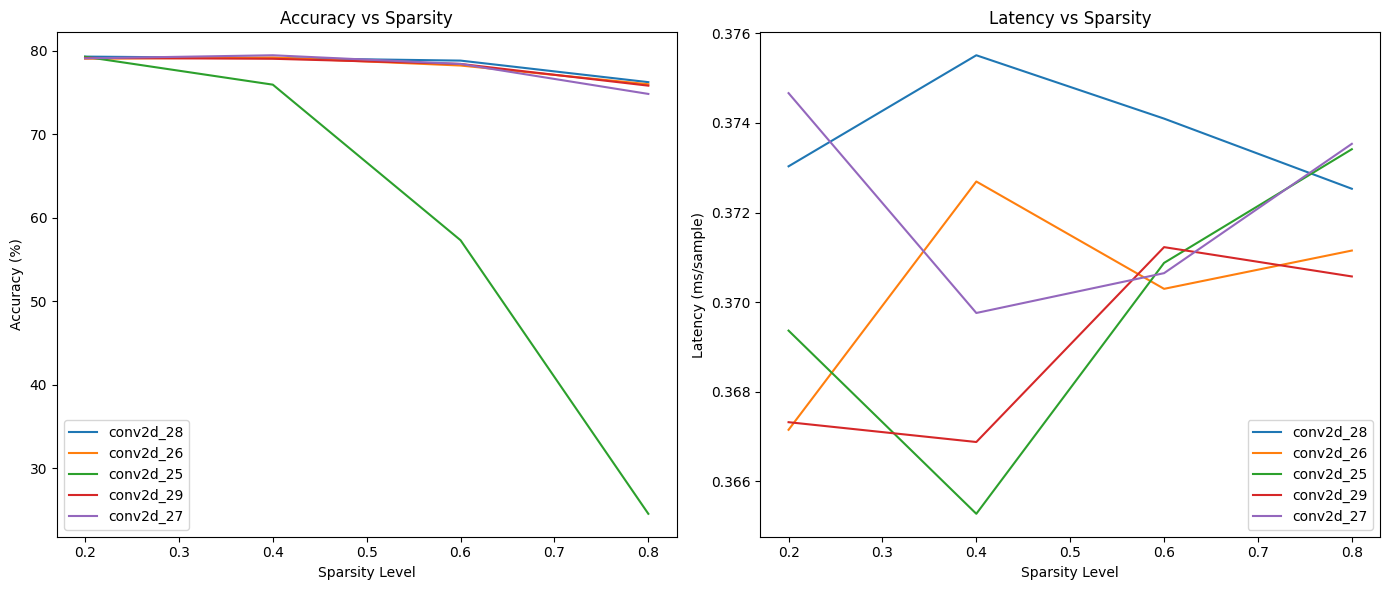

In [ ]:
# Display Results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)
# Plot Results
import matplotlib.pyplot as plt

# Accuracy vs Sparsity
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for layer_name in set(results["Layer"]):
    layer_indices = [i for i, name in enumerate(results["Layer"]) if name == layer_name]
    sparsity_values = [results["Sparsity"][i] for i in layer_indices]
    accuracy_values = [results["Accuracy"][i] for i in layer_indices]
    plt.plot(sparsity_values, accuracy_values, label=f"{layer_name}")

plt.xlabel("Sparsity Level")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Sparsity")
plt.legend()

# Latency vs Sparsity
plt.subplot(1, 2, 2)
for layer_name in set(results["Layer"]):
    layer_indices = [i for i, name in enumerate(results["Layer"]) if name == layer_name]
    sparsity_values = [results["Sparsity"][i] for i in layer_indices]
    latency_values = [results["Latency"][i] for i in layer_indices]
    plt.plot(sparsity_values, latency_values, label=f"{layer_name}")

plt.xlabel("Sparsity Level")
plt.ylabel("Latency (ms/sample)")
plt.title("Latency vs Sparsity")
plt.legend()

plt.tight_layout()
plt.show()
